In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Data Loading and Exploration

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')

try:
    users_df = pd.read_csv('../data/Users.csv')
    posts_df = pd.read_csv('../data/Posts.csv')
    engagements_df = pd.read_csv('../data/Engagements.csv')
except FileNotFoundError:
    print("Not Found....")
    
    
print("--- Users DataFrame ---")
display(users_df.head())

print("\n\n--- Posts DataFrame ---")
display(posts_df.head())

print("\n\n--- Engagements DataFrame ---")
display(engagements_df.head())

--- Users DataFrame ---


,user_id,age,gender,top_3_interests,past_engagement_score
0,U1,24,F,"sports, art, gaming",0.61
1,U2,32,F,"travel, food, fashion",0.93
2,U3,28,Other,"sports, travel, fashion",0.40
3,U4,25,M,"fashion, music, tech",0.53
4,U5,24,M,"fashion, food, fitness",0.80




--- Posts DataFrame ---


,post_id,creator_id,content_type,tags
0,P1,U44,video,"sports, food"
1,P2,U26,video,"music, travel"
2,P3,U32,text,"sports, travel"
3,P4,U6,image,"music, gaming"
4,P5,U32,image,"food, fashion"




--- Engagements DataFrame ---


,user_id,post_id,engagement
0,U1,P52,1
1,U1,P44,0
2,U1,P1,1
3,U1,P4,1
4,U1,P65,0


## Feature Engineering (Calculating Interest Match Scores for a given User)

In [7]:
tfidf = TfidfVectorizer(min_df=0.01, max_df=0.8)
user_interests_matrix = tfidf.fit_transform(users_df['top_3_interests'].str.replace(',', ''))
post_tags_matrix = tfidf.transform(posts_df['tags'].str.replace(',', ''))
interest_match_scores = cosine_similarity(user_interests_matrix, post_tags_matrix)
print(f"Shape of Interest Match Score Matrix: {interest_match_scores.shape}")

print("\n\n", interest_match_scores)

Shape of Interest Match Score Matrix: (50, 100)


 [[0.41998665 0.         0.40140386 ... 0.         0.35990239 0.62350046]
 [0.35340497 0.37907434 0.41343812 ... 0.         0.         0.        ]
 [0.45828922 0.36016366 0.83082485 ... 0.         0.         0.        ]
 ...
 [0.         0.33539324 0.36579725 ... 0.         0.36571544 0.        ]
 [0.         0.48498127 0.         ... 0.         0.47425757 0.60435423]
 [0.         0.82501604 0.35764553 ... 0.         0.48610538 0.        ]]


## Processing Demographic Features

In [5]:
scaler = StandardScaler()
users_df['age_scaled'] = scaler.fit_transform(users_df[['age']])

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
gender_encoded = encoder.fit_transform(users_df[['gender']])
gender_df = pd.DataFrame(gender_encoded, columns=encoder.get_feature_names_out(['gender']))
processed_users_df = pd.concat([users_df.reset_index(drop=True), gender_df], axis=1)
print("\nUsers DataFrame with new demographic features:")
display(processed_users_df.head())


Users DataFrame with new demographic features:


,user_id,age,gender,top_3_interests,past_engagement_score,age_scaled,gender_F,gender_M,gender_Other
0,U1,24,F,"sports, art, gaming",0.61,-0.346194,1.0,0.0,0.0
1,U2,32,F,"travel, food, fashion",0.93,1.384775,1.0,0.0,0.0
2,U3,28,Other,"sports, travel, fashion",0.40,0.519291,0.0,0.0,1.0
3,U4,25,M,"fashion, music, tech",0.53,-0.129823,0.0,1.0,0.0
4,U5,24,M,"fashion, food, fitness",0.80,-0.346194,0.0,1.0,0.0


## Training Dataset

In [8]:
user_id_to_idx = {user_id: i for i, user_id in enumerate(users_df['user_id'])}
post_id_to_idx = {post_id: i for i, post_id in enumerate(posts_df['post_id'])}

training_df = engagements_df.copy()
training_df['interest_score'] = training_df.apply(
    lambda row: interest_match_scores[user_id_to_idx[row['user_id']], post_id_to_idx[row['post_id']]],
    axis=1
)
training_df = training_df.merge(processed_users_df, on='user_id')
print("\nFinal Training DataFrame Ready for the Model:")
display(training_df.head())


Final Training DataFrame Ready for the Model:


,user_id,post_id,engagement,interest_score,age,gender,top_3_interests,past_engagement_score,age_scaled,gender_F,gender_M,gender_Other
0,U1,P52,1,0.359902,24,F,"sports, art, gaming",0.61,-0.346194,1.0,0.0,0.0
1,U1,P44,0,0.000000,24,F,"sports, art, gaming",0.61,-0.346194,1.0,0.0,0.0
2,U1,P1,1,0.419987,24,F,"sports, art, gaming",0.61,-0.346194,1.0,0.0,0.0
3,U1,P4,1,0.359902,24,F,"sports, art, gaming",0.61,-0.346194,1.0,0.0,0.0
4,U1,P65,0,0.552832,24,F,"sports, art, gaming",0.61,-0.346194,1.0,0.0,0.0


## Model Training

In [9]:
feature_cols = ['interest_score', 'past_engagement_score', 'age_scaled'] + list(gender_df.columns)
target_col = 'engagement'

X = training_df[feature_cols]
y = training_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

ml_ranker_model = LogisticRegression(random_state=42, class_weight='balanced')
ml_ranker_model.fit(X_train, y_train)

# Model Interpretation
coefficients = pd.DataFrame(ml_ranker_model.coef_[0], index=feature_cols, columns=['Coefficient'])
print("\nLearned Feature Importance:")
display(coefficients.sort_values('Coefficient', ascending=False))


Learned Feature Importance:


,Coefficient
gender_M,0.339265
interest_score,0.133278
gender_F,-0.009756
age_scaled,-0.018974
gender_Other,-0.256990
past_engagement_score,-0.458066


## Model Evaluation


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.45      0.46      0.45       101
           1       0.43      0.42      0.43        99

    accuracy                           0.44       200
   macro avg       0.44      0.44      0.44       200
weighted avg       0.44      0.44      0.44       200



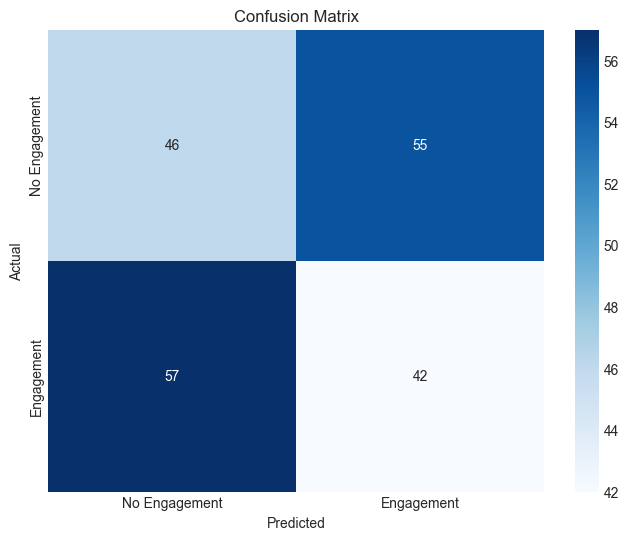

In [10]:
y_pred = ml_ranker_model.predict(X_test)
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Engagement', 'Engagement'], yticklabels=['No Engagement', 'Engagement'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Generating Recommendations

In [11]:
def get_ml_ranker_recommendations(user_id, top_n=3):
    user_idx = user_id_to_idx.get(user_id)
    if user_idx is None: return "User not found."

    engaged_posts = set(engagements_df[engagements_df['user_id'] == user_id]['post_id'])
    candidate_posts = posts_df[~posts_df['post_id'].isin(engaged_posts)].copy()
    if candidate_posts.empty: return "No new posts to recommend."

    user_info = processed_users_df.iloc[[user_idx]]
    prediction_df = pd.DataFrame(index=candidate_posts.index)
    prediction_df['interest_score'] = [interest_match_scores[user_idx, post_id_to_idx[pid]] for pid in candidate_posts['post_id']]
    for col in ['past_engagement_score', 'age_scaled'] + list(gender_df.columns):
        prediction_df[col] = user_info[col].values[0]

    probabilities = ml_ranker_model.predict_proba(prediction_df[feature_cols])[:, 1]
    candidate_posts['recommendation_score'] = probabilities
    
    return candidate_posts.sort_values('recommendation_score', ascending=False).head(top_n)

## Recommendations for User 'U23'

In [13]:
test_user = 'U23'
recommendations = get_ml_ranker_recommendations(test_user)
print(f"\n--- Recommendations for {test_user} ---")
display(users_df[users_df['user_id'] == test_user])
print("\nTop 3 Recommended Posts:")
display(recommendations[['post_id', 'tags', 'recommendation_score']])


--- Recommendations for U23 ---


,user_id,age,gender,top_3_interests,past_engagement_score,age_scaled
22,U23,29,F,"sports, food, literature",0.54,0.735662



Top 3 Recommended Posts:


,post_id,tags,recommendation_score
47,P48,"sports, literature",0.482969
56,P57,"sports, literature",0.482969
22,P23,"literature, food",0.481214
